In [1]:
import sys
sys.path.append('..')
from src.evo_eq_model import *

In [3]:
import random
import numpy.random as rnd
import networkx as nx
from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys
# from jupyter_server import serverapp as app; 
# import ipykernel, requests;
if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle

import pandas as pd
import scipy.interpolate as spi

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

from matplotlib.ticker import FuncFormatter

fmt = lambda x, pos: '{:.1f}'.format(x)
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')
plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=30
plt.rcParams['ytick.labelsize']=30
plt.rcParams['axes.labelsize']=35
plt.rcParams['legend.fontsize']= 35
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40
#set legend titlesize to 40
plt.rcParams['legend.title_fontsize'] = 40

In [4]:
def model(X, t, R0, kappa):
    x = X[0]
    y = X[1]
    z = X[2]
    dxdt = - R0/(1+kappa * y) *x * y
    dydt =  R0/(1+kappa* y) * x * y - y
    dzdt = y
    return [dxdt, dydt, dzdt]

@jit(nopython=True)    
def find_t_intersection(f,g, t):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return t[idx[0]]
    else:
        return np.inf

@jit(nopython=True)    
def find_ind_intersection(f,g):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return idx[0]
    else:
        return np.inf

In [25]:
N = 1e8
R0=beta=3
mu= 5e2/N
p_alpha = .1
kappa=0
xi = 50

In [26]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
output_folder= project_path+'/outputs/'

In [27]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
%autoreload
M_controlled = eqModel(N=N, infection_rate=beta, kappa= 100, recovery_rate=1, mutation_rate = mu, p_alpha= p_alpha,xi = xi, initial_infected=10,dt=None, figures_folder= None)
M_controlled.run_to_extinction(ignore_running=True)
print('done')

 16%|█▋        | 8426/51206 [00:47<04:00, 177.60it/s] 

done


In [29]:
M_uncontrolled = eqModel(N=N, infection_rate=beta, kappa= 0, recovery_rate=1, mutation_rate = mu, p_alpha= p_alpha,xi = xi, initial_infected=10,dt=None, figures_folder= None)
M_uncontrolled.run_to_peak()
print('done')

100%|██████████| 948/948 [00:01<00:00, 596.25it/s] 

done


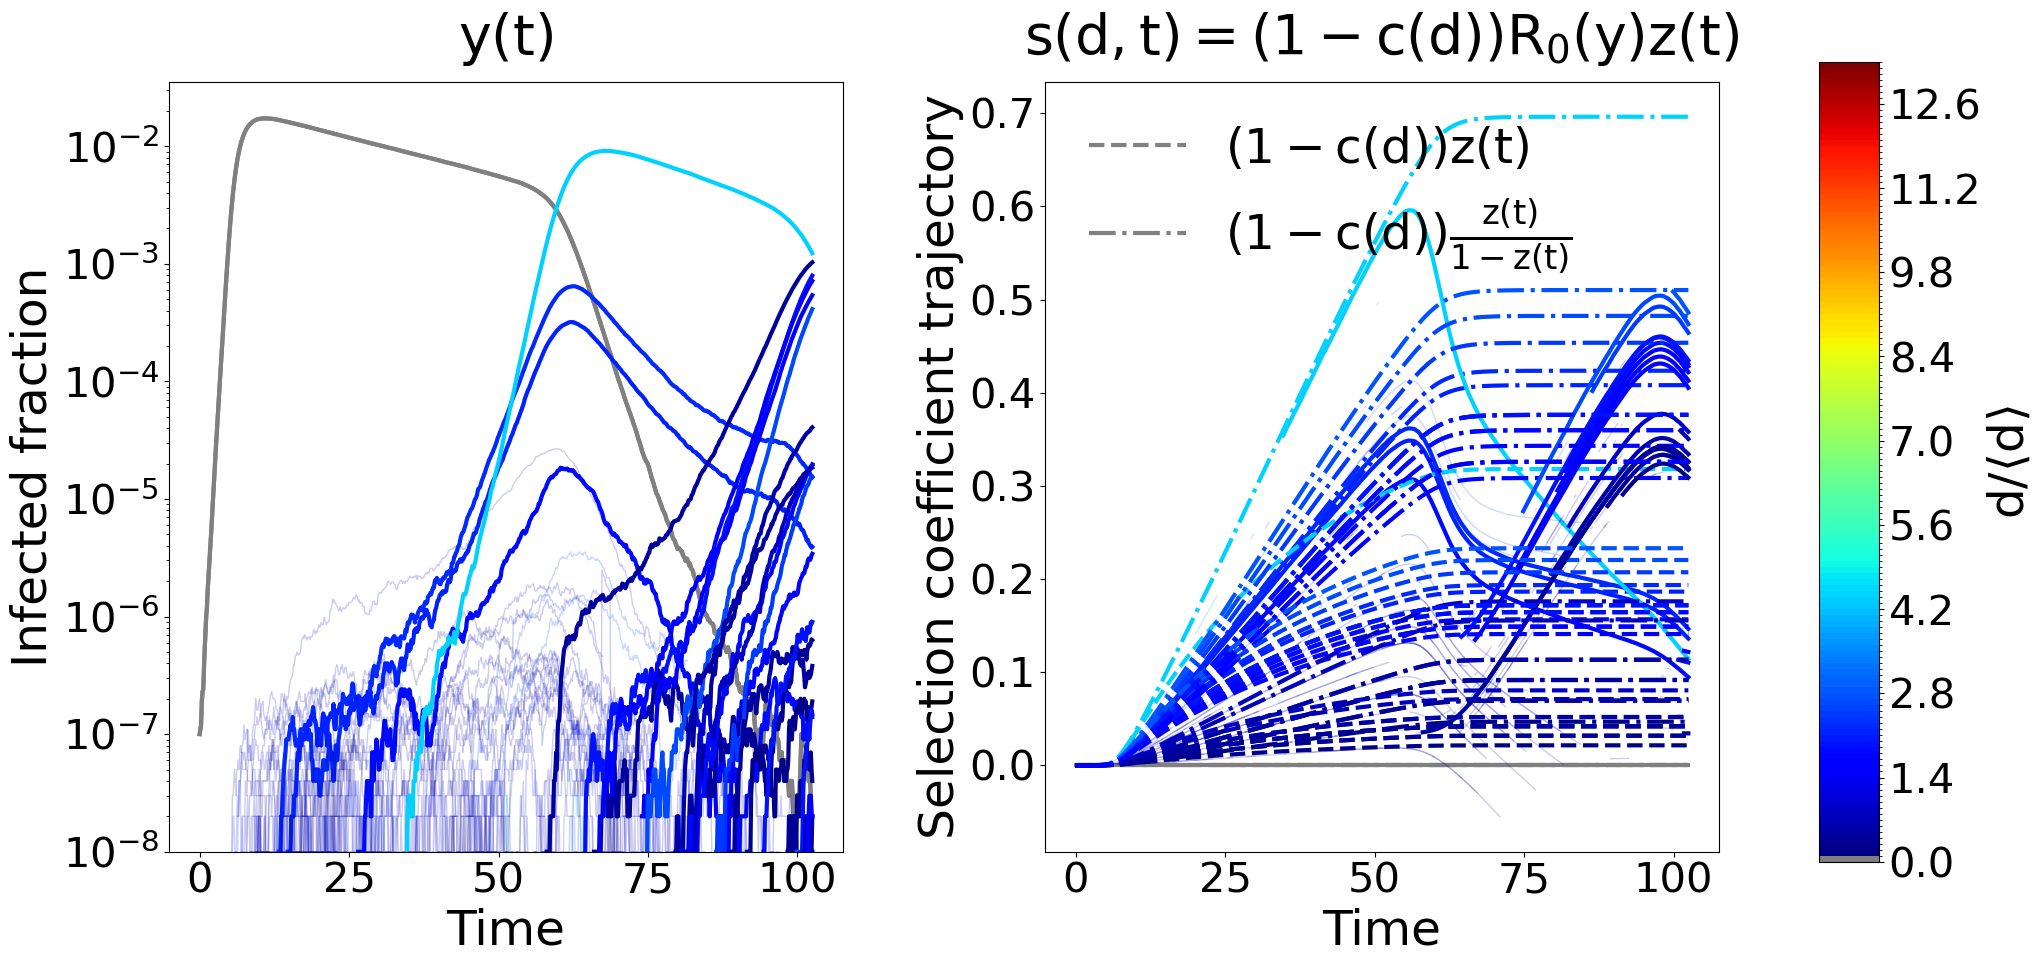

In [30]:
ds = np.arange(0,10 + 2*np.round(np.log(mu*N)/p_alpha))
color_ds= dict(zip(ds,plt.cm.jet(np.linspace(0,1,len(ds)))))

fig,ax =plt.subplots(1,2,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=.1,wspace=.3)
y0p = (R0-1-np.log(R0))/R0

xinf = M_controlled.find_x_inf(R0,kappa)
T = M_controlled.calc_T(R0,kappa,N)
zinf = 1-xinf
ts_det = np.linspace(0,T,1000)
x,y,z= odeint(model, np.array([1-10/N,10/N,0]), ts_det, args=(R0,kappa)).T


#get the three strains with the highest infected size
big_strains = sorted(M_controlled.strain_set, key=lambda x: x.recovered_size, reverse=True)[:5]
big_names=  [strain.name for strain in big_strains]

if True:
    ts_root= np.array(M_controlled.root_strain.times)
    I_root = np.array(M_controlled.root_strain.infected_history)
    S_root = np.array(M_controlled.root_strain.susceptible_history)
    R_root = np.array(M_controlled.root_strain.recovered_history)
    xparent = S_root/N
    zparent = R_root/N
    yparent = I_root/N
    t_peak = ts_root[np.argmax(I_root)]
    legend_ds = {}

for strain in M_controlled.strain_set:
    if strain.name==0:
        color='grey'
    else:
        color = color_ds[strain.distance_to_parent]

    I_i = np.array(strain.infected_history)
    if len(I_i)==0:
        continue

    c= np.exp(-strain.distance_to_parent/xi)
    s_inf = R0*(1-xinf)*(1-c)
    

    chi_i = np.array(strain.frequency_history)
    s_i = np.array(strain.selection_history)
    ts_i = np.array(strain.times)
    d_pc = strain.distance_to_parent
    
    if strain.root_intersection_time<np.inf or strain.name==0:
        
        # ax[1].axhline(s_inf,color=color,ls='--')
        t_i0 = ts_i[0]
        chi_0 = chi_i[0]
        if t_i0<t_peak:
            t_i0 = t_peak

            # ax[0].axvline(ts_i[np.argmin(np.abs(ts_i-t_peak))],color=color,ls='--')
        
        # ax[0].axhline(chi_0,color=color,ls='--')
        # ax[0].plot(ts_i, chi_0*np.exp(s_inf*(ts_i-t_i0)),color=color,ls=':')
        alpha= 1
        lw= 3
        # ax[1].plot(ts_root, R0/(1+ kappa*yparent)*(1-c)*zparent,color=color, alpha= alpha, lw = lw, linestyle=':')
        ax[1].plot(ts_root, (1-c)*zparent,color=color, alpha= alpha, lw = lw, linestyle='--')
        ax[1].plot(ts_root, (1-c)*zparent/(1-zparent),color=color, alpha= alpha, lw = lw, linestyle='-.')
        # ax[1].plot(ts)

    else: 
        alpha = .2
        lw= 1
    if strain.name ==0:
        ax[0].plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= alpha, lw = lw)
    ax[0].plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= alpha, lw = lw)
    ax[1].plot(ts_i,s_i ,color=color, alpha= alpha, lw = lw)    

for a in ax:
    a.set_xlabel('Time')
    
ax[0].set_title('$y(t)$',pad=20)
ax[0].set_ylabel('Infected fraction')
ax[0].set_yscale('log')
# ax[0].set_ylim((1/N,1))

ax[1].set_title(r'$s(d,t) = \left(1-c(d)\right) R_0 (y) z(t) $',pad=20)
ax[1].set_ylabel('Selection coefficient trajectory')

approx_handles = [mpl.lines.Line2D([0], [0], color='grey', lw=3, linestyle='--'), mpl.lines.Line2D([0], [0], color='grey', lw=3, linestyle='-.')]
approx_labels = [r'$\left(1-c(d)\right) z(t)$',r'$\left(1-c(d)\right) \frac{z(t)}{1-z(t)}$']

ax[1].legend(handles=approx_handles,labels=approx_labels,loc='best',frameon=False)
ax[0].set_ylim(bottom=1/N)
cmap = plt.cm.jet  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (.5, .5, .5, 1.0)
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = ds*p_alpha
norm = mpl.colors.BoundaryNorm(ds*p_alpha, cmap.N)
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                cax=ax2, orientation='vertical', label=r'$d/\langle d \rangle$', ticks=bounds[::14], boundaries=bounds[::14],format=FuncFormatter(fmt))#, format='%1f')
# for a in ax:
#     a.set_xlim(0,500)

In [31]:
root_strain_controlled = M_controlled.root_strain
chi0s_t0s_controlled = np.array([(x.initial_frequency,x.birth_time) for x in root_strain_controlled.children])
tp = M_controlled.root_strain.times[np.argmax(M_controlled.root_strain.infected_history)]
chi_min = 1/(np.max(M_controlled.root_strain.infected_history))

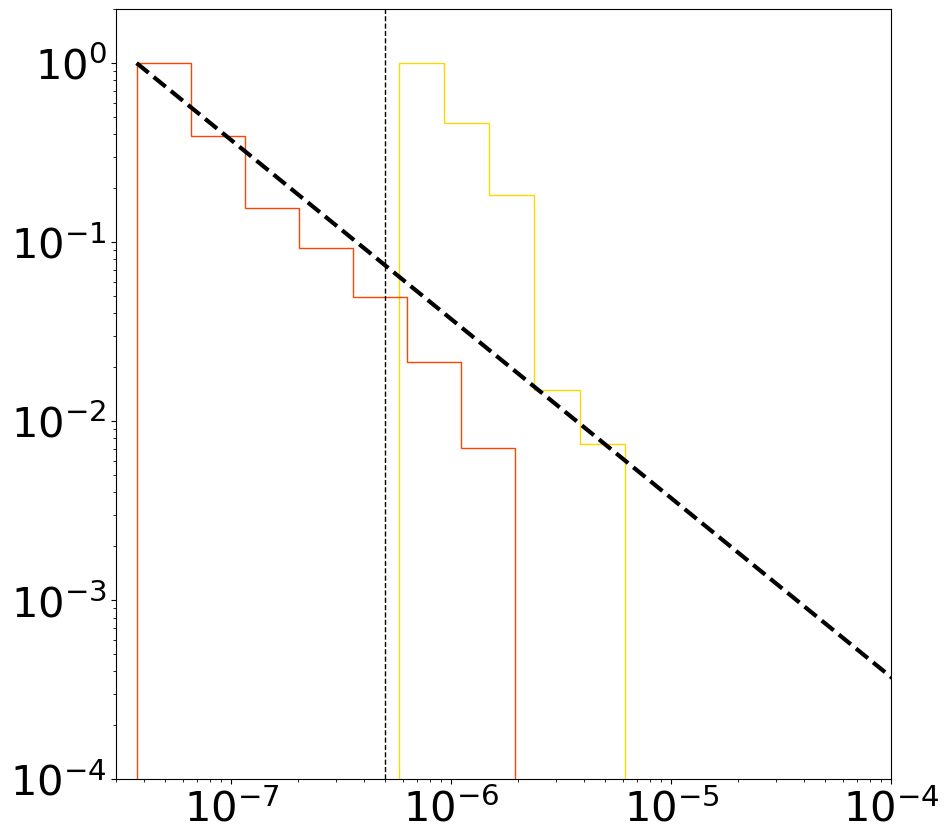

In [35]:
root_strain_controlled = M_controlled.root_strain
root_strain_uncontrolled = M_uncontrolled.root_strain

chi0s_controlled = [x.initial_frequency for x in root_strain_controlled.children]
chi0s_uncontrolled = [x.initial_frequency for x in root_strain_uncontrolled.children]


chi0s_vals_smooth = np.logspace(np.log10(np.min(chi0s_uncontrolled)),np.log10(0.5),101)
chi0s_vals_uncontrolled = np.logspace(np.log10(np.min(chi0s_uncontrolled)),np.log10(0.5),30)
chi0s_vals_controlled = np.logspace(np.log10(np.min(chi0s_controlled)),np.log10(0.5),30)

#formula =  (-\[Kappa] - N0 \[Chi] + N0 R0 \[Chi])/(N0 R0 \[Chi] (1 - (-\[Kappa] - N0 \[Chi] + N0 R0 \[Chi])/(N0 R0 \[Chi])))/(R0/\[Kappa] \[Chi]^2)
chi_formula = lambda chi,kappa, R0, N: (-kappa - N*chi + N*R0*chi)/(N*R0*chi*(1 - (-kappa - N*chi + N*R0*chi)/(N*R0*chi)))/(R0/kappa *chi**2)

chi_formula_vals= np.array([chi_formula(chi,M_controlled.kappa,R0,N) for chi in chi0s_vals_smooth])
chi_formula_vals/= np.trapz(chi_formula_vals[chi_formula_vals>0],chi0s_vals_smooth[chi_formula_vals>0])

savefig = True
fig1 = False
if fig1:
    fig,ax= plt.subplots(1,1,figsize=(10,10))
    ax.hist(chi0s_controlled, bins=chi0s_vals_controlled, density=True, alpha=0.5);
    ax.plot(chi0s_vals_smooth, chi_formula_vals)

    simple_plaw = chi0s_vals_smooth**(-2)

    simple_plaw /= simple_plaw[48]
    ax.plot(chi0s_vals_smooth,simple_plaw)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(bottom= 1/N, top = np.max(chi_formula_vals)*20.1)
    ax.axvline(1/(N*yp), color='k', linestyle='--')
    ax.set_ylim(bottom=1)

fig2 = True
if fig2:
    fig,ax= plt.subplots(1,1,figsize=(10,10))
    ax.hist(chi0s_controlled, bins=chi0s_vals_controlled, density=True, alpha=1,cumulative=-1,histtype='step',color='gold');
    ax.hist(chi0s_uncontrolled, bins=chi0s_vals_uncontrolled, density=True, alpha=1,cumulative=-1,histtype='step',color='orangered');
    
    simple_plaw = chi0s_vals_smooth**(-1)

    simple_plaw /= simple_plaw[0]
    ax.plot(chi0s_vals_smooth,simple_plaw,color='black',linestyle='--')
    
    ax.set_ylim(bottom= 1/N, top = np.max(chi_formula_vals)*20.1)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.axvline(1/(N*(R0-1)/M_controlled.kappa), color='k', linestyle='--',lw=1)
    ax.set_ylim(top=2, bottom=1e-4)
    ax.set_xlim(left=3e-8, right=1e-4)
# if savefig:
#     plt.savefig(output_folder+'fig4_a.svg',bbox_inches='tight')